# Plot the ffCO2

In [1]:
import os
import sys
import glob
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from dateutil.relativedelta import relativedelta

import acrg.obs as obs
from acrg.name import name
from acrg.convert import concentration

import han_func, emiss_func, plot_info


In [2]:
year = 2014
months = [1, 2, 3, 4, 5, 6] #[7, 8, 9, 10, 11, 12] #, [8, 12] # 
site = 'WAO'
ox_ratio_inv = ['gridfed-ukghg']#, 'gridfed']

alpha_l = 1.07

starts = {month: datetime(year, month, 1) for month in months}
ends = {month: start + relativedelta(months=1) for month, start in starts.items()}

ocean = 'nonmasked' # -3 #'masked' #
date_str = f'{year}' if months==[mm for mm in range(1, 13)] else \
           f'{year}01-06' if months== [mm for mm in range(1, 7)] else \
           f'{year}07-12' if months== [mm for mm in range(7, 13)] else None

## Calculate the APO:ffCO2 ratio

Calculated in another script:
1. Import the footprint
2. Find the proportion of footprint within each grid cell
3. Import the oxidative ratio
4. Multiply the oxidative ratio by the weighted footprint to get a weighted oxidative ratio map
5. Sum the weighted oxidative ratio map



In [7]:
filenames = {ratio: {inv: os.path.join('/user', 'work', 'vf20487', 'Timeseries', 'OxidativeRatio',
                               f'Weighted{ratio}Ratio-{inv}_timeseries_{year}.nc')
                     for inv in ox_ratio_inv}
             for ratio in ['APO', 'Oxidative']}
ratios_weighted = {ratio: {inv: name.open_ds(filename_inv) for inv, filename_inv in filenames_ratio.items()}
                   for ratio, filenames_ratio in filenames.items()}

### Plot the ratios

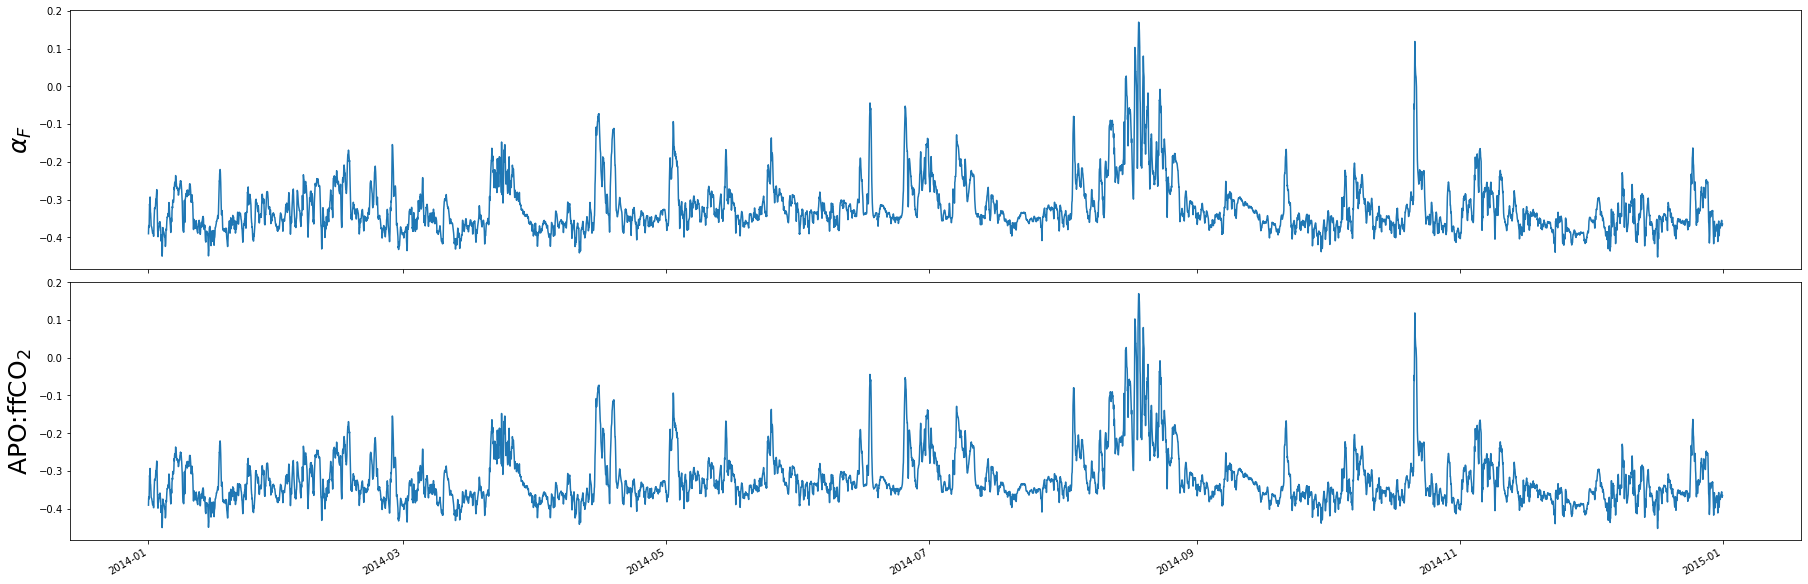

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25, 8), constrained_layout=True, sharex=True)

plots = [[ratio[f'{ratio_name.lower()}_ratio'].plot(ax=axes[rr], label=inv) for inv, ratio in ratios.items()]
         for rr, (ratio_name, ratios) in enumerate(ratios_weighted.items())]

xlabel = [ax.set_xlabel('') for ax in axes]
ylabels = [axes[ll].set_ylabel(label, fontsize=25)
           for ll, label in enumerate([r'$\alpha_F$', r'APO:ffCO$_2$'])]

## Get the APO timeseries

Get the timeseries for the site and the backround (MHD)

In [4]:
ts_data_all = han_func.get_timeseries(sites = [site],
                                      year = year,
                                      sources = ['bc', 'ff', 'ocean'])
ts_data_months = {site: {month: ts_site.sel(time=slice(start, ends[month]))
                         for month, start in starts.items()}
                  for site, ts_site in ts_data_all.items()}

Finding timeseries for WAO
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2014.nc']
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2014.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2014.nc']

Data variables:
['co2_ff', 'apo_bc', 'co2_bc', 'o2_bc', 'o2_ff', 'o2_ocean_nemo', 'n2_ocean_nemo', 'o2_ocean_ecco', 'o2_ocean_jena', 'co2_ocean_nemo']


### Test going from ffO2 to ffCO2

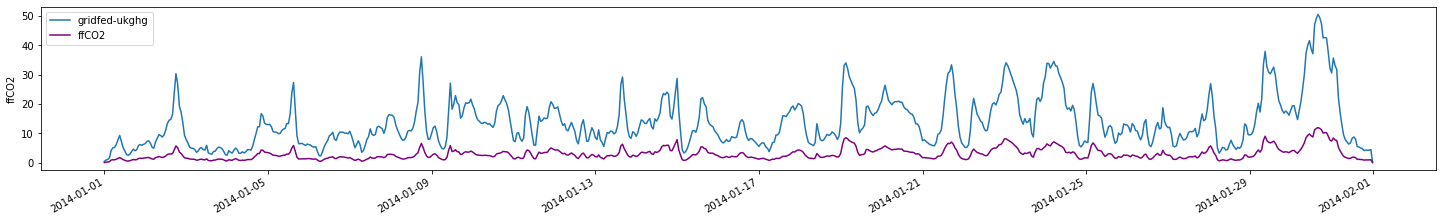

In [8]:
ff_co2 = {inv: ts_data_months[site][months[0]]['o2_ff'] / ox_ratio.oxidative_ratio for inv, ox_ratio in ratios_weighted['Oxidative'].items()}

fig, ax = plt.subplots(1, 1, figsize=(25, 3))
[ff_co2_inv.plot(ax=ax, label=inv) for inv, ff_co2_inv in ff_co2.items()]
ts_data_months[site][months[0]].co2_ff.plot(ax=ax, color='purple', label='ffCO2')
legend = ax.legend(loc='best')
xlabel = ax.set_xlabel('')
ylabel = ax.set_ylabel('ffCO2')

### Calculate APO

In [26]:
apo_model = {site_name: {month: {ocean_sim: emiss_func.apo(ocean_o2 = ts_month[f'o2_ocean_{ocean_sim}'],
                                                           ocean_co2 = ts_month.co2_ocean_nemo,
                                                           ocean_n2 = ts_month.n2_ocean_nemo,
                                                           ff_co2 = ts_month.co2_ff,
                                                           ff_o2 = ts_month.o2_ff) #+ ts_site.apo_bc 
                                for ocean_sim in ['ecco', 'jena', 'nemo']}
                        for month, ts_month in ts_site.items()}
            for site_name, ts_site in ts_data_months.items()}

ffco2 = {site: {month: {ocean_sim: {inv: apo_ocean / ratio.apo_ratio
                                    for inv, ratio in ratios_weighted['APO'].items()}
                        for ocean_sim, apo_ocean in apo_site[month].items()}
                for month, apo_month in apo_site.items()}
         for site, apo_site in apo_model.items()}

### Calculate ffCO2

Use the APO:ffCO2 ratio to estime ffCO2

In [27]:
### plot the modelled ffCO2 with a varying oxidative ratio
inv_plot = ['gridfed', 'gridfed-ukghg']
sim_plot = ['ecco', 'jena', 'nemo']
sim_names = {'ecco': 'ECCO', 'jena': 'Jena', 'nemo': 'NEMO'}
color = {'gridfed': 'violet', 'gridfed-ukghg': 'dodgerblue'}
ls = {'gridfed': '--', 'gridfed-ukghg': '-.'}
label = {'gridfed': 'GridFED', 'gridfed-ukghg': 'GridFED-NAEI'} if len(ox_ratio_inv)>1 else \
        {ox_ratio_inv[0]: 'APO-derived'}

# convert the units to ppm
ffco2_ppm = {site: {month: {ocean_sim: {inv: ff_inv*0.2094 for inv, ff_inv in ff_ocean.items()}
                            for ocean_sim, ff_ocean in ff_month.items() if ocean_sim in sim_plot}
                    for month, ff_month in ffco2_site.items()}
             for site, ffco2_site in ffco2.items()}

ffco2_ppm = {site: {month: {ocean_sim: {inv: ff_inv.where((ff_inv>-40) & (ff_inv<40)).load()
                                        for inv, ff_inv in ff_ocean.items()}
                            for ocean_sim, ff_ocean in ff_month.items()}
                    for month, ff_month in ffco2_site.items()}
             for site, ffco2_site in ffco2_ppm.items()}

### Plot ffCO2

Saving to /user/work/vf20487/Figures/Timeseries/ffCO2/ffCO2_APO_WAO_201401-06.png


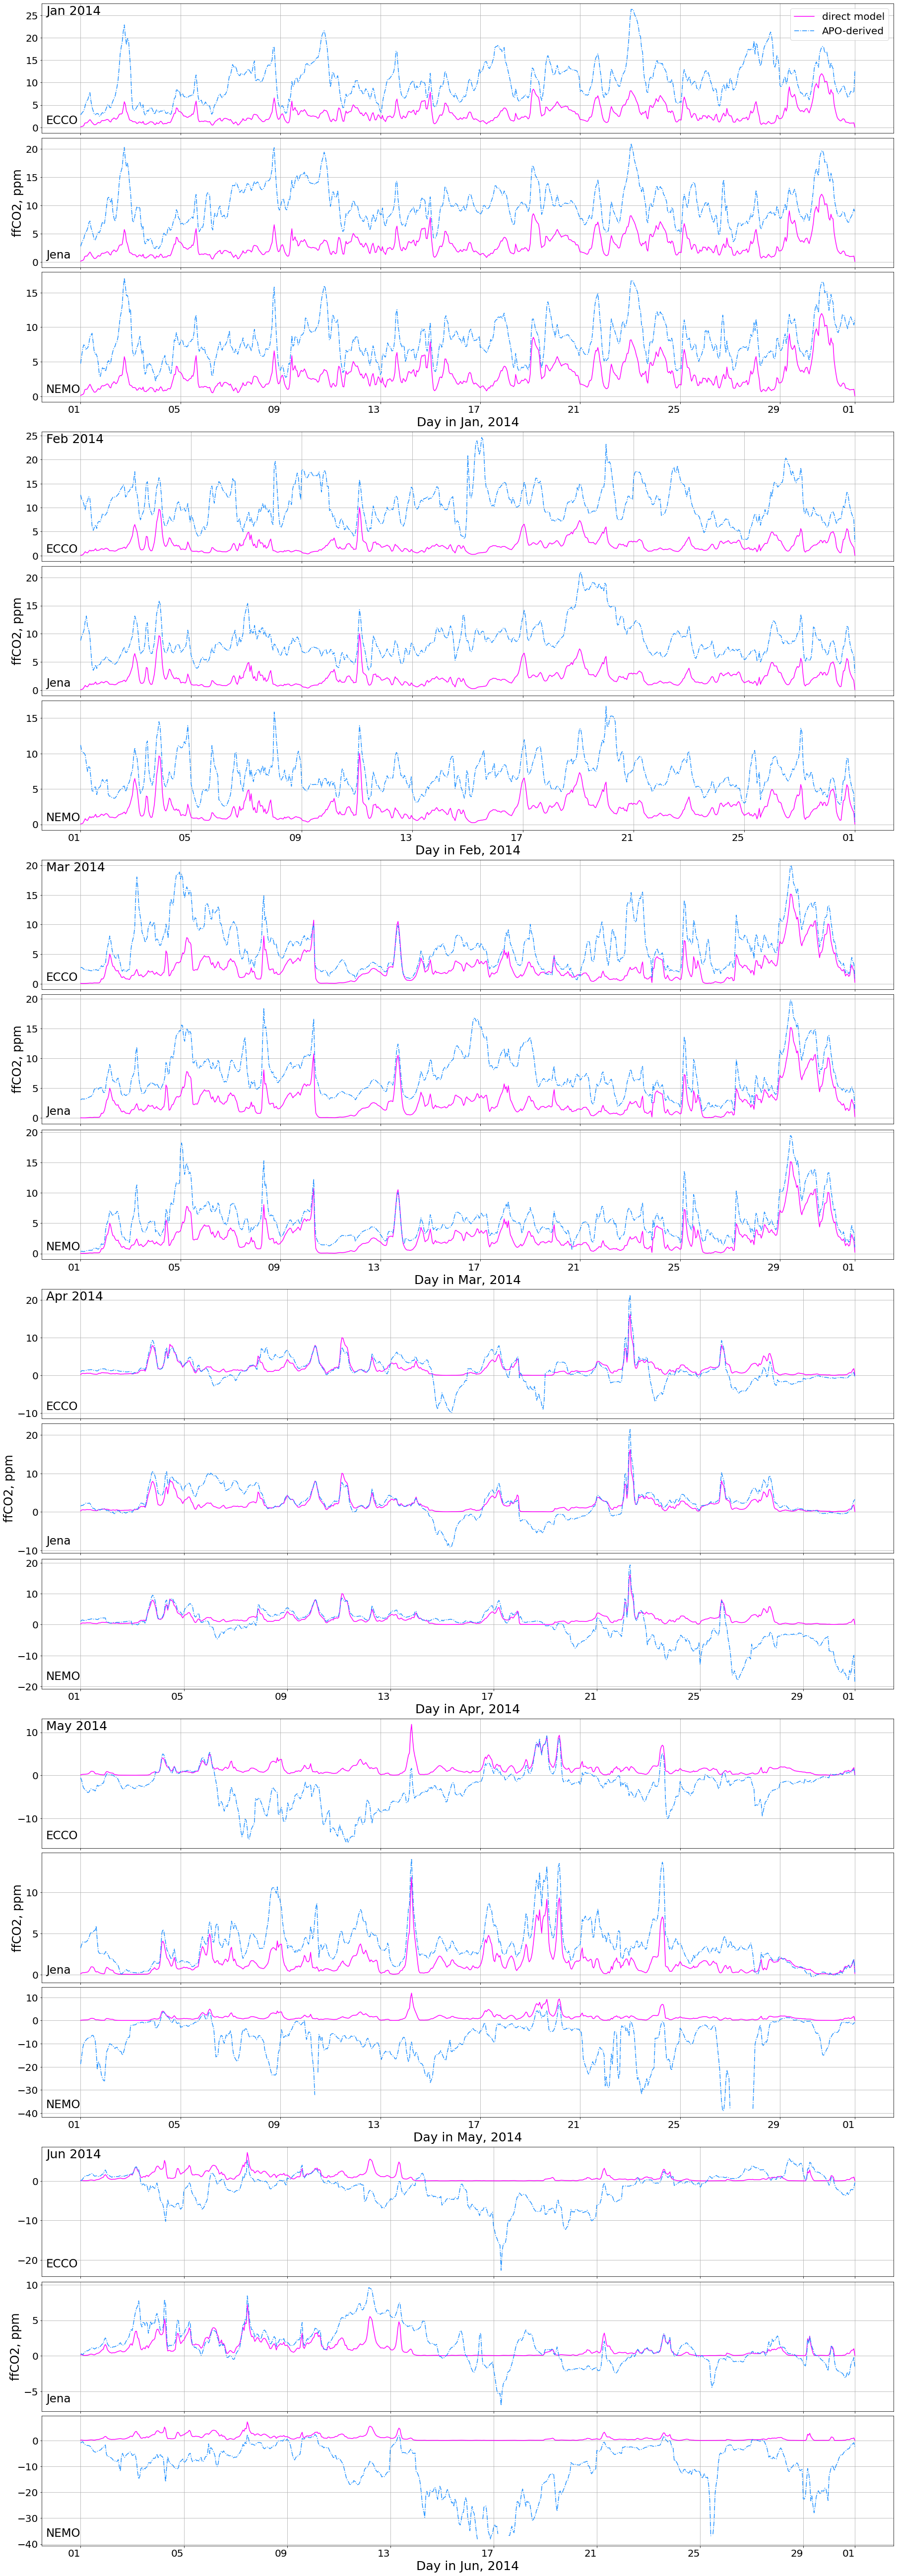

In [28]:
# plot the nemo & ecco models on separate axes
fig, axes = plt.subplots(nrows=len(sim_plot)*len(months), ncols=1, figsize=(25, 4*len(sim_plot)*len(months)), constrained_layout=True)
# height_ratios = sum([[4]*len(sim_plot) + [0.2] for mm in range(len(months)-1)], []) + [4]*len(sim_plot)
# fig, axes = plt.subplots(nrows=len(sim_plot)*len(months)+1, ncols=1, figsize=(25, 4*len(sim_plot)*len(months)), constrained_layout=True,
#                          gridspec_kw=dict(height_ratios=height_ratios, hspace=0))

# plot the NAEI timeseries
[[ts_data_month.co2_ff.plot(ax=axes[ii+tt*len(sim_plot)], label='direct model', color='magenta') for ii in range(len(sim_plot))]
 for tt, ts_data_month in enumerate(ts_data_months[site].values())]

# plot the APO-derived ffCO2 timeseries
apo_plots = {month: [[ff.plot(ax=axes[ss+mm*len(sim_plot)], label=label[inv], color=color[inv], ls=ls[inv])
                      for inv, ff in ff_ocean.items() if inv in inv_plot]
                     for ss, (sim, ff_ocean) in enumerate(ff_month.items())]
            for mm, (month, ff_month) in enumerate(ffco2_ppm[site].items())}
text = [[axes[ss+mm*len(sim_plot)].text(0.005, 0.05, sim_names[sim], transform=axes[ss+mm*len(sim_plot)].transAxes, va='bottom', fontsize=23)
         for ss, sim in enumerate(ff_month.keys())]
        for mm, (month, ff_month) in enumerate(ffco2_ppm[site].items())]

legend = axes[0].legend(loc='upper right', fontsize=20)
xlabel = [ax.set_xlabel('') for ax in axes]
[axes[m*len(sim_plot)+2].set_xlabel(f'Day in {plot_info.month_names[month]}, {year}', fontsize=25)
 for m, month in enumerate(months)]
ylabel = [ax.set_ylabel('') for ax in axes]

if len(months)==1:
        ylabel = axes[1].set_ylabel('ffCO2, ppm', fontsize=24)
if len(months)==2:
        ylabel = fig.text(-0.01, 0.52, 'ffCO2, ppm', va='center', ha='center', rotation='vertical', fontsize=25)
else:
        ylabels = [axes[ii-1].set_ylabel('ffCO2, ppm', fontsize=24) for ii in [i for i in range(0, len(axes)) if (i+1)%3==0]]

myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
text = [axes[mm*3].text(0.005, 0.985, f'{plot_info.month_names[month]} {year}', transform=axes[mm*3].transAxes, va='top', fontsize=25)
        for mm, month in enumerate(months)]

ticks = [ax.tick_params(labelsize=20) for ax in axes]
[axes[ii].xaxis.set_ticklabels([]) for ii in range(0, len(axes)) if ii not in [m*len(sim_plot)+2 for m in range(0, len(months))]]
grid = [ax.grid() for ax in axes]

out_date_str = f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
               '_'.join([f'{year}{str(month).zfill(2)}' for month in months])
mask_str = '' if ocean=='nonmasked' else '_maskedocean' if ocean=='masked' else f'oceanOR{ocean}'
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'ffCO2',
                        f'ffCO2_APO{mask_str}_{site}_{out_date_str}.png')
print(f'Saving to {filename}')
# fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

### Plot all models onto the same axis

Saving to /user/work/vf20487/Figures/Timeseries/ffCO2/ffCO2_APO_all_WAO_201401-06.png


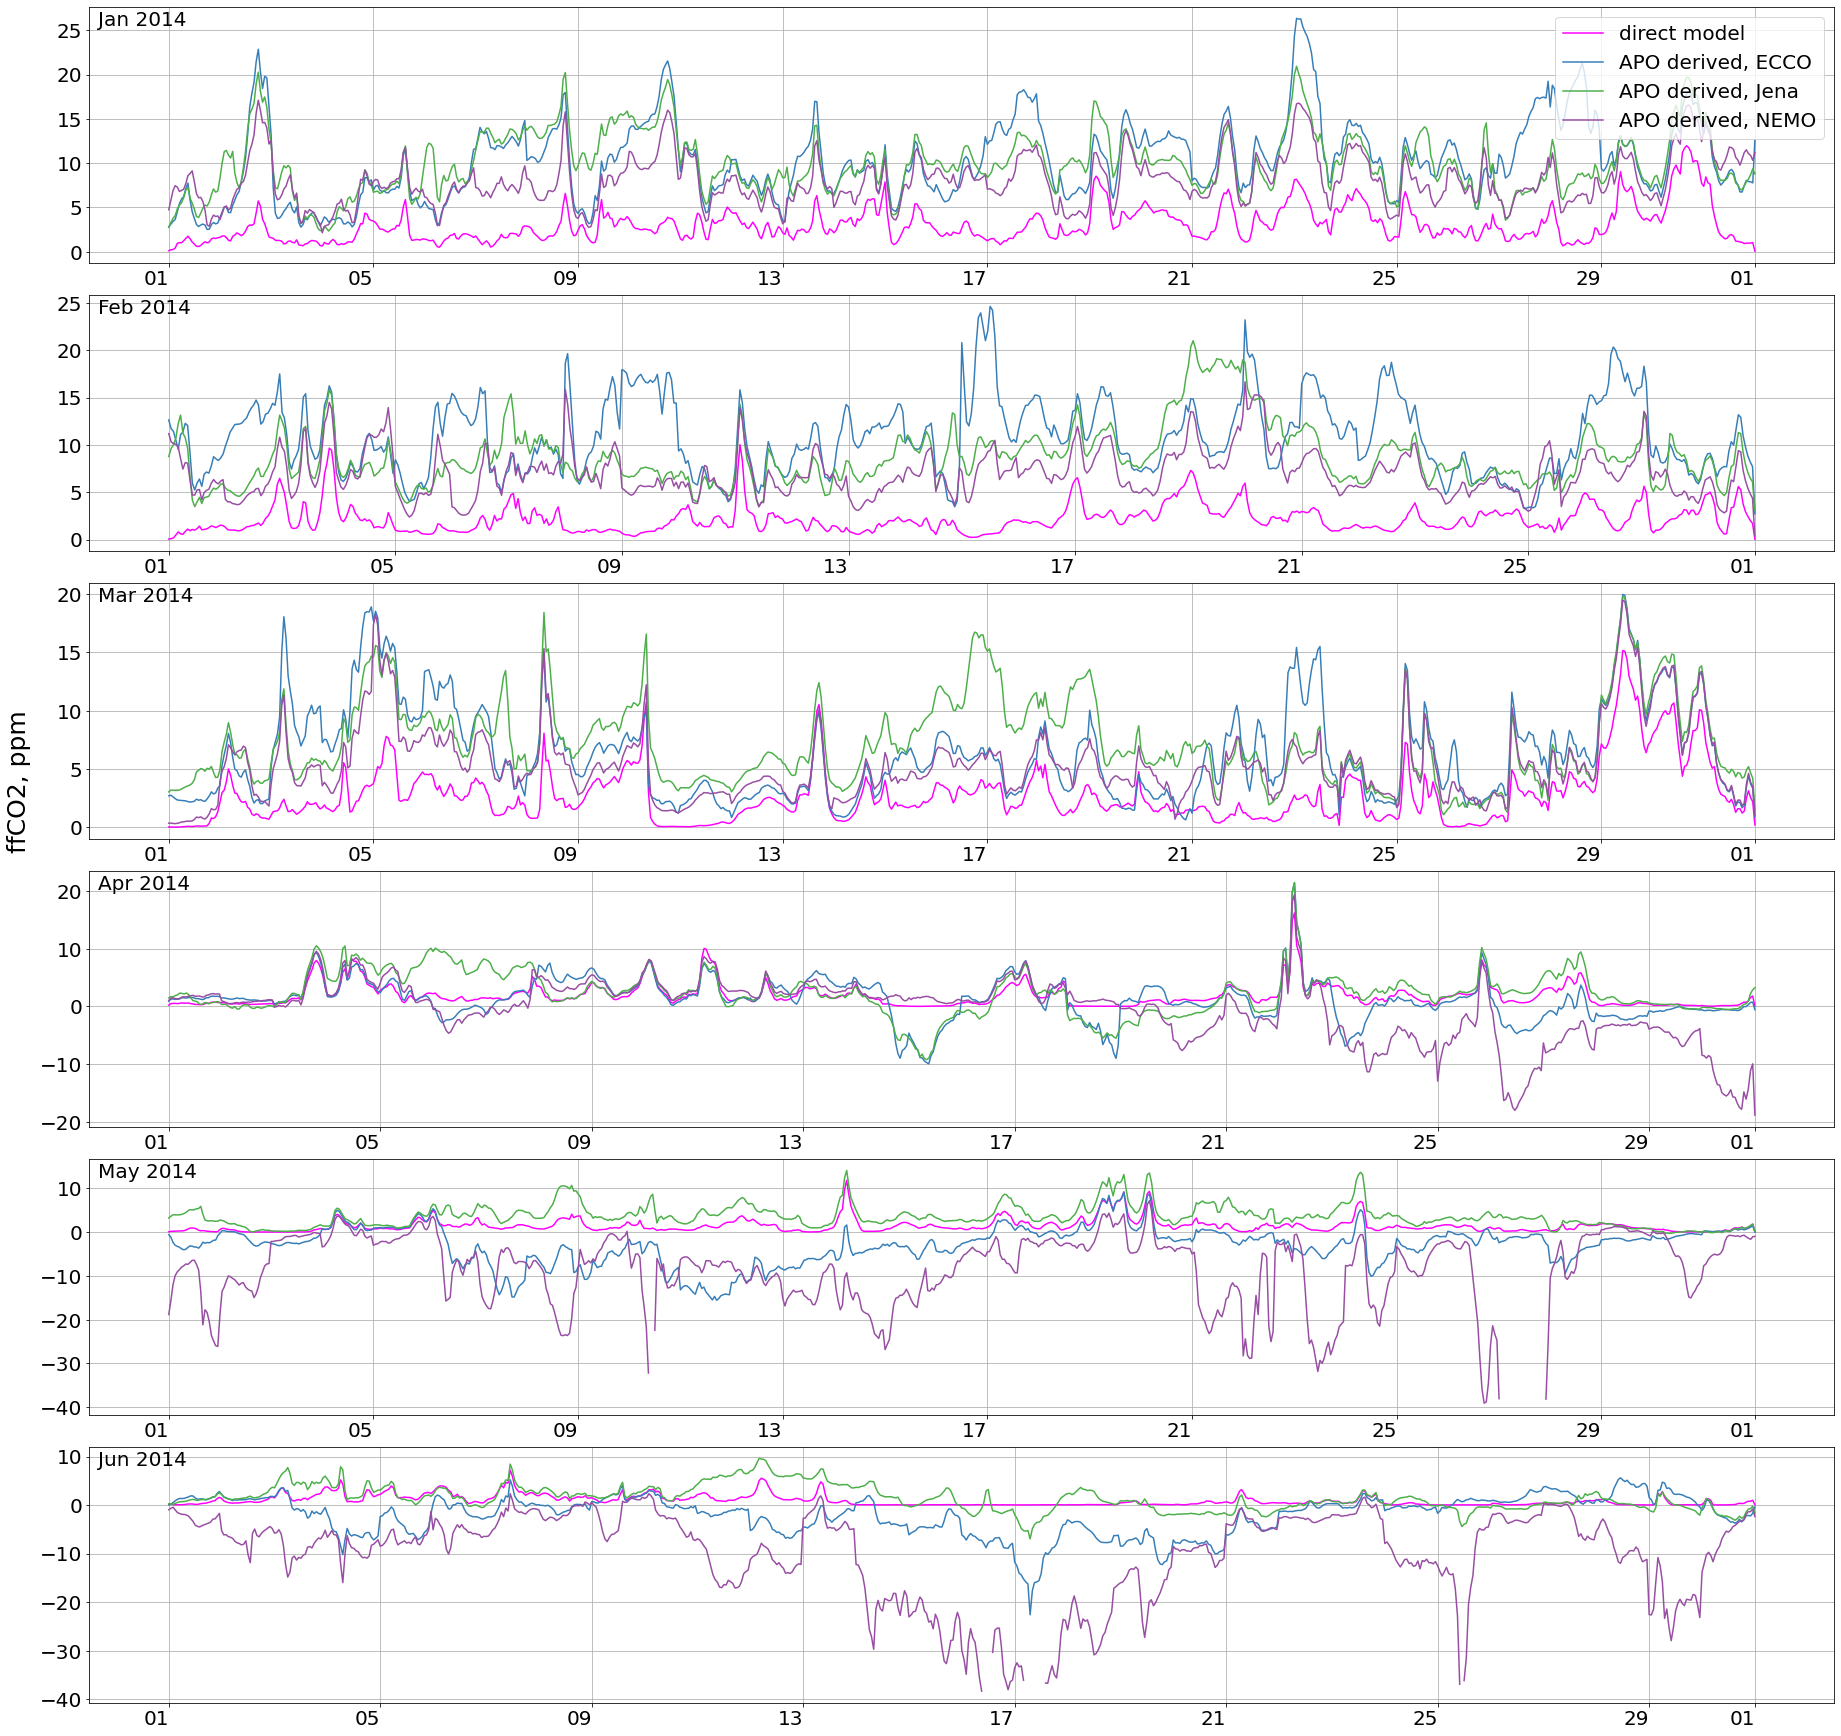

In [34]:
row_size = 5 if len(months)<=2 else 4
# plot the nemo & ecco models on separate axes
fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, row_size*len(months)), constrained_layout=True)
axes = [axes] if type(axes) not in [np.ndarray, list] else axes

# plot the NAEI timeseries
[ts_data_month.co2_ff.plot(ax=axes[tt], label='direct model', color='magenta')
 for tt, ts_data_month in enumerate(ts_data_months['WAO'].values())]

# labels = {sim: f'APO derived, {plot_info.model_names[sim]}' for sim in ffco2_ppm['WAO'][1].keys()}
# plot the APO-derived ffCO2 timeseries
apo_plots = {month: [[ff.plot(ax=axes[mm], label=f'APO derived, {plot_info.model_names[sim]}', color=plot_info.colors[sim])
                      for inv, ff in ff_ocean.items() if inv in inv_plot]
                     for ss, (sim, ff_ocean) in enumerate(ff_month.items())]
            for mm, (month, ff_month) in enumerate(ffco2_ppm['WAO'].items())}

text = [axes[mm].text(0.005, 0.985, f'{plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
        for mm, month in enumerate(ffco2_ppm['WAO'].keys())]

legend_loc = 'upper right' if months==[m for m in range(1, 7)] else 'lower right'
legend = axes[0].legend(loc=legend_loc, fontsize=20)
xlabel = [ax.set_xlabel('') for ax in axes]
ylabel = [ax.set_ylabel('') for ax in axes]

if len(months)==1:
        ylabel = axes.set_ylabel('ffCO2, ppm', fontsize=24)
if len(months)>1:
        ylabel = fig.text(-0.01, 0.55, 'ffCO2, ppm', va='center', ha='center', rotation='vertical', fontsize=25)

myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
grid = [ax.grid() for ax in axes]

out_date_str = f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
               '_'.join([f'{year}{str(month).zfill(2)}' for month in months])
mask_str = '' if ocean=='nonmasked' else '_maskedocean' if ocean=='masked' else f'oceanOR{ocean}'
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'ffCO2',
                        f'ffCO2_APO_all{mask_str}_{site}_{out_date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)